# Classification of Bat Hunting Calls

offene Fragen:
- Sprache (deutsch/englisch)
- Vorverarbeitung wav -> spec
- reicht aktuelle Visualisierung der PCA aus?
- Länge des Notebooks?
- Wie viele verschiedene Methoden ausprobieren?

## Project by Johannes Maaß and Maja Gentsch


#### (Machine Learning Course, Prof. Vogel)

In [82]:
import librosa
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import io
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


## Raw Data - EDA

In [111]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

db_path = 'batcallsv14.db'

with sqlite3.connect(db_path) as db_con:
    cursor = db_con.cursor()

    n = cursor.execute("select count(*) from batcalls;")
    print(f"Anzahl Einträge: {n.fetchone()[0]}")

    head_df = pd.read_sql("select * from batcalls limit 10;", db_con)
head_df

Anzahl Einträge: 51719


,call,target,id,bat,arr,db
0,38818,0,0,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba
1,46731,0,1,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba
2,49137,0,2,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba
3,49557,0,3,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba
4,22197,0,4,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba
5,11958,0,5,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba
6,15446,0,6,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba
7,44262,0,7,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba
8,46273,0,8,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba
9,34856,0,9,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba


In [84]:
with sqlite3.connect(db_path) as db_con:

    bat_names = pd.read_sql("select bat, count(*) as number from batcalls group by bat;", db_con)
    bat_names.transpose()

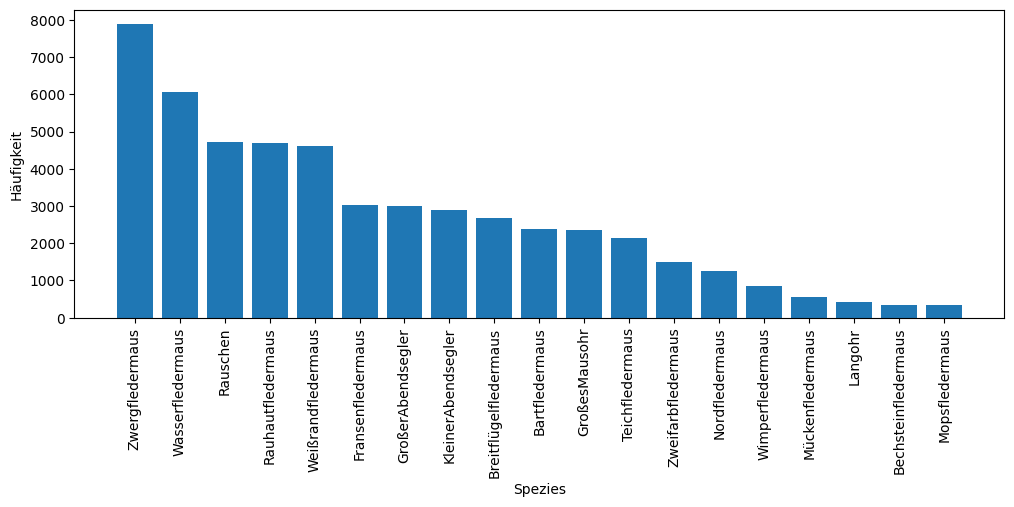

In [112]:
%matplotlib inline
sorted_bats = bat_names.sort_values(by='number', ascending=False)
fig, ax = plt.subplots(figsize=(12,4))
plt.bar(sorted_bats['bat'],sorted_bats['number'])
plt.xticks(rotation=90)
plt.ylabel("Häufigkeit")
plt.xlabel("Spezies")
plt.show()

Wir haben einen Datensatz mit 51719 Einträgen mit folgenden Attributen:
- call: wahrscheinlich Nummerierung der Aufnahmen
- target: numerische Codierung der Klasse
- id: Tabellen-spezifische ID
- bat: nominaler Wert von Target (Bezeichnung der Fledermaus)
- arr: Aufnahmen der Jagdrufe
- db: ?

Insgesamt sind 18 verschiedene Fledermausarten und Rauschen aufgenommen worden. Die Arten sind eher ungleich verteilt.

Wir werden im Folgenden die sechs am häufigsten vorkommenden Fledermäuse und das Rauschen verwenden, um verschiedene Modelle auszuprobieren.

In [113]:
our_bats = bat_names.sort_values(by='number', ascending=False).head(7)
our_bats

,bat,number
18,Zwergfledermaus,7885
14,Wasserfledermaus,6074
12,Rauschen,4713
11,Rauhautfledermaus,4695
15,Weißrandfledermaus,4619
3,Fransenfledermaus,3040
4,GroßerAbendsegler,3005


In [114]:
targets = list(our_bats.index)

In [88]:
targets

[18, 14, 12, 11, 15, 3, 4]

## Data Collection and Preprocessing

In [89]:
import librosa
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import io
import sqlite3
import os
from scipy.signal import butter, lfilter

In [115]:
def _convert_array(text):
	out = io.BytesIO(text)
	out.seek(0)
	return np.load(out, allow_pickle=True)
    
def _adapt_array(arr):
	out = io.BytesIO()
	np.save(out, arr)
	out.seek(0)
	return sqlite3.Binary(out.read())
    
def butter_bandpass(lowcut, highcut, fs, order=5):
  nyq = 0.5 * fs
  low = lowcut / nyq
  high = highcut / nyq
  b, a = butter(order, [low, high], btype='band')
  return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
  b, a = butter_bandpass(lowcut, highcut, fs, order=order)
  y = lfilter(b, a, data)
  return y

def make_sets(data_rows, targets):
  spec_list = []
  label_list = []
  for row in data_rows:
    #target_class = targets.index(row[1])
    target_class = row[1]
    call = row[4].astype(np.float32, order='C') / 32768.0

    # Bandpass to filter low and high frequencies
    data_bp = butter_bandpass_filter(call, 1500, 12000, 44100, 5)

    # Normalize
    data_bp -= np.mean(data_bp)
    data_bp /= np.std(data_bp)

    # Calculate spectrogram with FFT
    stft = np.abs(librosa.stft(data_bp, n_fft=512, hop_length=32))
    stft = 10 * np.log10(stft)
    stft = np.nan_to_num(stft)

    # Scale between [0,1] and reduce shape if needed
    stft = (stft - np.min(stft)) / (np.max(stft) - np.min(stft))
    stft = np.reshape(stft, (257, 138, 1))
    stft = stft[:256, -128: , :] #Größe der Spektrogramme festlegen

    spec_list.append(stft)
    label_list.append(target_class)
  return spec_list, label_list

In [116]:
def load_spectrograms(data_path, num_per_class, targets) -> list:

    num_calls = num_per_class
    all_rows = []

    sqlite3.register_adapter(np.ndarray, _adapt_array)
    sqlite3.register_converter("ARRAY", _convert_array)
    
    with sqlite3.connect(db_path, detect_types=True) as con:
      cur = con.cursor()
      for target in targets:
        if num_calls > 0:
          rows = [x for x in cur.execute(f"SELECT * FROM batcalls WHERE target = {target} LIMIT {num_calls}")]
        else:
          rows = [x for x in cur.execute(f"SELECT * FROM batcalls WHERE target = {target}")]
        all_rows.extend(rows)

    spectrograms, labels = make_sets(all_rows, targets)
    return spectrograms, labels

In [117]:
X, y = load_spectrograms(data_path="./data", num_per_class=100, targets=targets)
print(len(X))

/var/folders/5x/xl546rz52y15rf55pdkv6tg80000gn/T/ipykernel_5026/552949315.py:41: RuntimeWarning:

divide by zero encountered in log10



700


In [118]:
frequency = {cl : 0 for cl in y}
for cl in y:
    frequency[cl]+=1
frequency

{18: 100, 14: 100, 12: 100, 11: 100, 15: 100, 3: 100, 4: 100}

In [119]:
X_3d = X.copy() #brauchen wir später für Convolution

In [120]:
X[0].shape

(256, 128, 1)

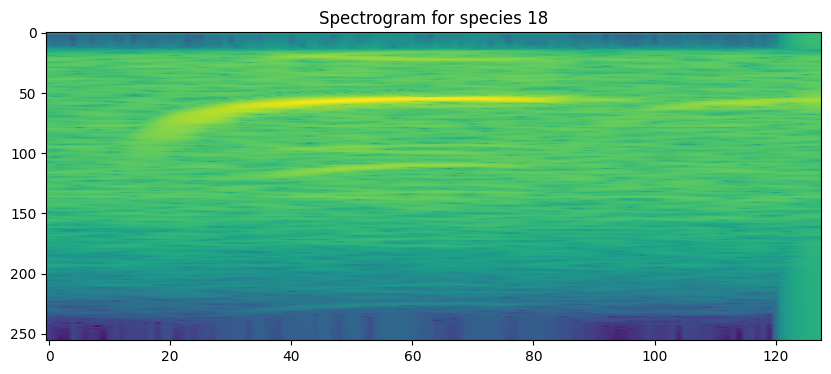

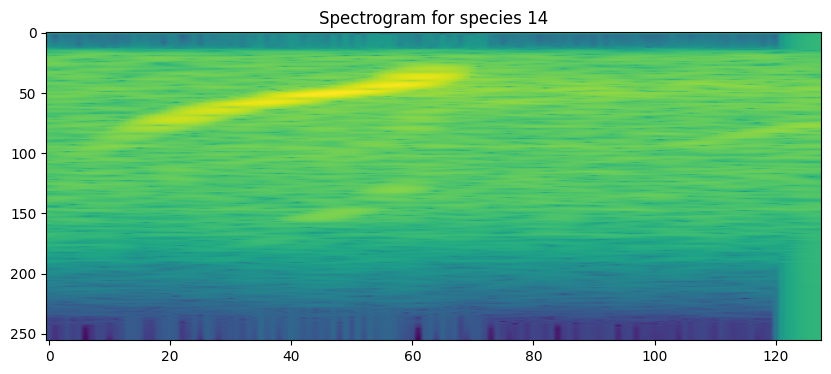

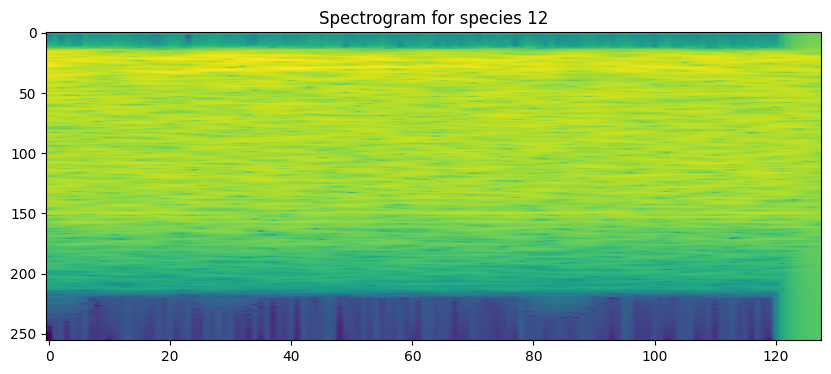

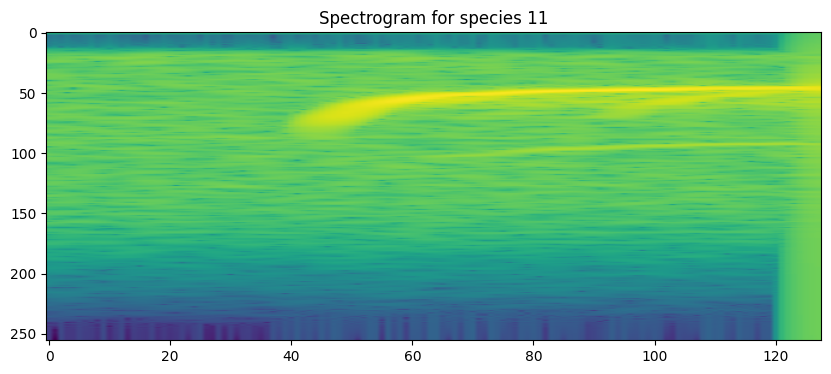

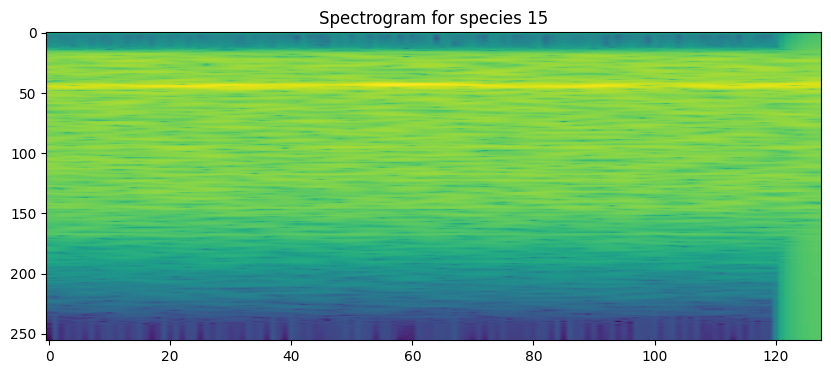

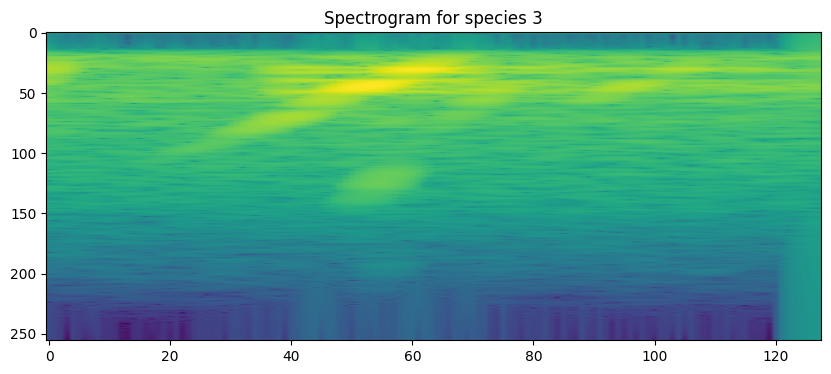

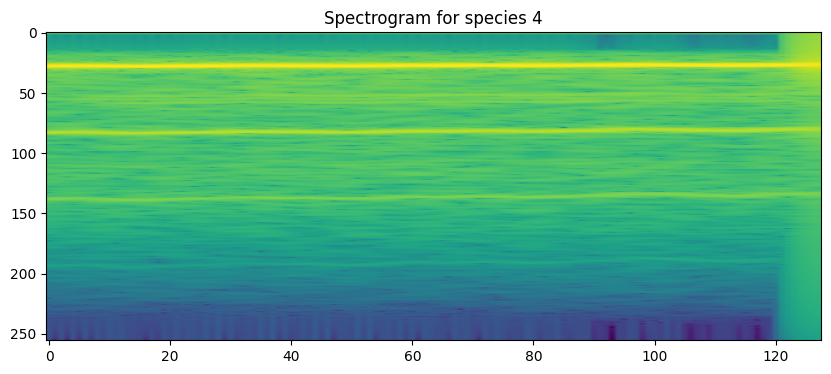

In [121]:
for label in frequency.keys():
    i = y.index(label)
    fig, ax = plt.subplots(figsize=(10,4))
    ax.imshow(X[i][:,:,0],aspect='auto')
    plt.title("Spectrogram for species " + str(y[i]))

In [122]:
for i in range(len(X)):
    X[i] = X[i].reshape(256,128)

In [123]:
X[3].shape

(256, 128)

## Methoden

### 1.1 PCA

In [54]:
flat_X_unscaled = np.array([spec.flatten() for spec in X])
flat_X = StandardScaler().fit_transform(flat_X_unscaled)
flat_X.shape

(700, 32768)

#### n_components = 2 (nur zur Veranschaulichung)

Da die PCA einen Vektor und keine Matrix als Input erwartet, müssen wir die einzelnen "Zeilen" des Spektrogramms aneinander hängen, dazu nutzen wir die numpy Funktion nd_array.flatten():

Wir möchten die PCA einmal mit den als "Rauschen" beschriebenen Daten und einmal ohne machen. Dazu erstellen wir im Folgenden eine Liste, in der nur die Spektrogramme tatsächlicher Fledermäuse drin sind.

In [55]:
only_bat_flat_X = []
only_bat_y = []
is_bat = [cl != 12 for cl in y]
for i in range(len(flat_X)):
    if(is_bat[i]):
        only_bat_flat_X.append(flat_X[i])
        only_bat_y.append(y[i])
np.array(only_bat_flat_X).shape

(600, 32768)

Zur Veranschaulichung wenden wir auf alle Daten eine PCA an, die die Fetaure-Vektoren auf 2 Hauptkomponenten reduziert:

In [56]:
from sklearn.decomposition import PCA
#PCA auf alle unsere Fledermaus-Instanzen
only_bat_reduced_X = PCA(n_components=2).fit_transform(only_bat_flat_X)
#PCA auf Fledermaus-Instanzen und Rauschen
reduced_X = PCA(n_components=2).fit_transform(flat_X)
reduced_X.shape

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Pyth

(700, 2)

In [57]:
#Dataframes für Ergebnisse beider PCAs erstellen (inkl. der zugehörigen Klasse)
reduced_data = pd.DataFrame(data = reduced_X, columns=["x1","x2"])
reduced_data.insert(2, "y", y)

only_bat_reduced_data = pd.DataFrame(data = only_bat_reduced_X, columns=["x1","x2"])
only_bat_reduced_data.insert(2, "y", only_bat_y)

In [58]:
our_bats

,bat,number
18,Zwergfledermaus,7885
14,Wasserfledermaus,6074
12,Rauschen,4713
11,Rauhautfledermaus,4695
15,Weißrandfledermaus,4619
3,Fransenfledermaus,3040
4,GroßerAbendsegler,3005


##### Plot 2D PCA inkl. Rauschen

Text(0, 0.5, 'x2')

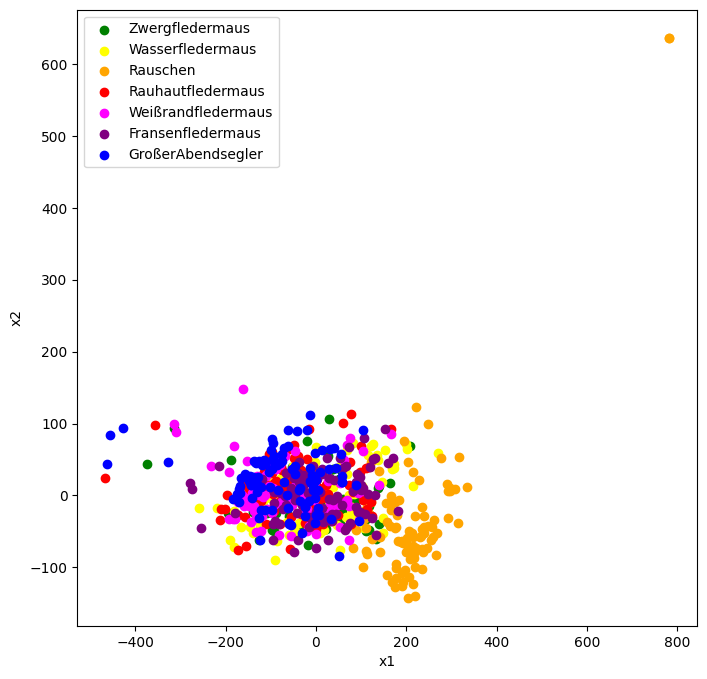

In [59]:
fig, ax = plt.subplots(figsize=(8,8))
plt.scatter(reduced_data[reduced_data['y'] == 18]['x1'], 
            reduced_data[reduced_data['y'] == 18]['x2'],
            color="green", label="Zwergfledermaus")
plt.scatter(reduced_data[reduced_data['y'] == 14]['x1'], 
            reduced_data[reduced_data['y'] == 14]['x2'],
            color="yellow", label="Wasserfledermaus")
plt.scatter(reduced_data[reduced_data['y'] == 12]['x1'], 
            reduced_data[reduced_data['y'] == 12]['x2'],
            color="orange", label="Rauschen")
plt.scatter(reduced_data[reduced_data['y'] == 11]['x1'], 
            reduced_data[reduced_data['y'] == 11]['x2'],
            color="red", label="Rauhautfledermaus")
plt.scatter(reduced_data[reduced_data['y'] == 15]['x1'], 
            reduced_data[reduced_data['y'] == 15]['x2'],
            color="magenta", label="Weißrandfledermaus")
plt.scatter(reduced_data[reduced_data['y'] == 3]['x1'], 
            reduced_data[reduced_data['y'] == 3]['x2'],
            color="purple", label="Fransenfledermaus")
plt.scatter(reduced_data[reduced_data['y'] == 4]['x1'], 
            reduced_data[reduced_data['y'] == 4]['x2'],
            color="blue", label="GroßerAbendsegler")
plt.legend()
plt.xlabel("x1")
plt.ylabel("x2")

In dieser Grafik sind die beiden Hauptkomonenten x1 und x2 der Spektrogramme der Fledermaus-Arten und des Rauschens dargestellt.
Dabei kann man erkennen, dass die verschiedenen Fledermaus-Spezies in diesen Eigenschaften sehr ähnlich sind, während als "Rauschen" beschriebene Aufnahmen (alles außer Fledermäuse) sich etwas vom Rest der Daten abheben.

In nachfolgender Grafik ist das Ergebnis der PCA ohne Rauschen dargestellt. Hier lässt sich zumindest ansatzweise eine Differnzierung des Großen Abendseglers von den anderen Klassen erkennen.

##### Plot 2D PCA exkl. Rauschen

Text(0, 0.5, 'x2')

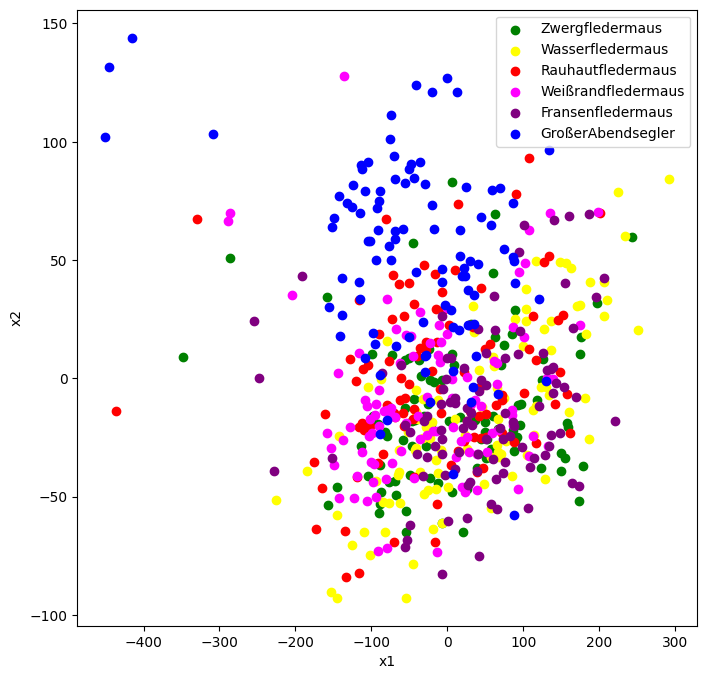

In [60]:
fig, ax = plt.subplots(figsize=(8,8))
plt.scatter(only_bat_reduced_data[only_bat_reduced_data['y'] == 18]['x1'], 
            only_bat_reduced_data[only_bat_reduced_data['y'] == 18]['x2'],
            color="green", label="Zwergfledermaus")
plt.scatter(only_bat_reduced_data[only_bat_reduced_data['y'] == 14]['x1'], 
            only_bat_reduced_data[only_bat_reduced_data['y'] == 14]['x2'],
            color="yellow", label="Wasserfledermaus")
plt.scatter(only_bat_reduced_data[only_bat_reduced_data['y'] == 11]['x1'], 
            only_bat_reduced_data[only_bat_reduced_data['y'] == 11]['x2'],
            color="red", label="Rauhautfledermaus")
plt.scatter(only_bat_reduced_data[only_bat_reduced_data['y'] == 15]['x1'], 
            only_bat_reduced_data[only_bat_reduced_data['y'] == 15]['x2'],
            color="magenta", label="Weißrandfledermaus")
plt.scatter(only_bat_reduced_data[only_bat_reduced_data['y'] == 3]['x1'], 
            only_bat_reduced_data[only_bat_reduced_data['y'] == 3]['x2'],
            color="purple", label="Fransenfledermaus")
plt.scatter(only_bat_reduced_data[only_bat_reduced_data['y'] == 4]['x1'], 
            only_bat_reduced_data[only_bat_reduced_data['y'] == 4]['x2'],
            color="blue", label="GroßerAbendsegler")
plt.legend()
plt.xlabel("x1")
plt.ylabel("x2")

#### n_components = 3 (nur zur Veranschaulichung)

In [61]:
only_bat_reduced_X_3D = PCA(n_components=3).fit_transform(only_bat_flat_X)
reduced_X_3D = PCA(n_components=3).fit_transform(flat_X)

labels = {18: "Zwergfledermaus", 14: "Wasserfledermaus", 12: "Rauschen", 
          11: "Rauhautfledermaus", 15: "Weißrandfledermaus", 3: "Fransenfledermaus", 
          4: "GroßerAbendsegler"}
y_labels = [labels[cl] for cl in y]
only_bat_y_labels = [labels[cl] for cl in only_bat_y]

#Dataframes für Ergebnisse beider PCAs erstellen (inkl. der zugehörigen Klasse)
reduced_data_3D = pd.DataFrame(data = reduced_X_3D, columns=["x","y","z"])
reduced_data_3D.insert(3, "bat", y_labels)
 
only_bat_reduced_data_3D = pd.DataFrame(data = only_bat_reduced_X_3D, columns=["x","y","z"])
only_bat_reduced_data_3D.insert(3, "bat", only_bat_y_labels)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Pyth

##### Plot 3D PCA inklusive Rauschen

In [62]:
import plotly.express as px
df = px.data.iris()
fig = px.scatter_3d(reduced_data_3D, x='x', y='y', z='z', color='bat', 
                    opacity=0.7)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

##### Plot 3D PCA exklusive Rauschen

In [63]:
df = px.data.iris()
fig = px.scatter_3d(only_bat_reduced_data_3D, x='x', y='y', z='z', color='bat', 
                    opacity=0.7)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

Bei der Reduzierung durch PCA auf 3 Dimensionen ist schon eine bessere Abgrenzung zu erkennen. Leider haben wir bisher keine bessere Darstellungsmöglichkeit der 3D-Daten gefunden.
Im Folgenden wollen wir für verschiedene n_components den K-Nearest-Neighbour ausprobieren.

### 1.2 KNN

Um die Wirksamkeit der PCA für eine Klassifikation zu testen, werden wir im Folgenden das **Ergebnis der PCA** mit verschiedenen Größen für den Parameter **n_components** für eine **K-Nearest-Neighbor** Klassifikation verwenden.
Das Ziel ist es, das optimale k und n_components zu finden.

**n_components**: gibt an, auf wie viele Dimensionen in der Hauptkomponentenanalyse reduziert wird. Unsere Vermutung ist, dass sowohl eine zu niedrige Dimension als auch eine zu hohe Dimensionalität des Input-Vektors für den KNN-Algorithmus schwierig ist. Ist die Dimension zu niedrig, sind einfach zu wenige Unterschiede zwischen den Samples erkennbar. Dahingegen würde eine zu hohe Dimensionalität dazu führen, dass KNN nicht die richtigen Features miteinander vergleicht. Die Distanz zweier Datenpunkte wird komponentenweise verglichen und aufsummiert, sodass leichte "Verschiebungen" in sonst sehr ähnlichen Datenpunkten zu einer großen Distanz der Datenpunkte führen könnten.

**k**: Das k bestimmt die Anzahl an Nachbarn, die beim Majority Voting einbezogen werden. Ist das k klein, können einzelne Ausreißer zu einer Fehlklassifikation von Daten führen, die ansonsten sehr gut abgrenzbar wären (wenn sich der Ausreißer im Feature-Space mitten in Punkten einer anderen Klasse befindet). Ist das K zu groß, können vor allem Punkte an Klassen-Grenzen im Feature-Space fehlklassifiziert werden. 

#### Funktionen

In [64]:
from sklearn import neighbors
from tqdm import tqdm

In [65]:
def get_accuracy_knn(range_neighbors, X_train, X_test, y_train, y_test):
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    k_neighbors = range_neighbors
    test_accuracy = []
    train_accuracy = []
    max_test_acc = 0
    best_knn_model = 0
    
    for k in k_neighbors:
        knn_classifier = neighbors.KNeighborsClassifier(k, weights='uniform')
        knn_classifier.fit(X_train, y_train)

        test_acc = knn_classifier.score(X_test, y_test)
        test_accuracy.append(test_acc)
        train_accuracy.append(knn_classifier.score(X_train, y_train))

        if test_acc > max_test_acc:
            max_test_acc = test_acc
            best_knn_model = knn_classifier
    return test_accuracy, train_accuracy, best_knn_model

In [66]:
def try_dimensions_and_neighbors(range_dimensions, range_neighbors, X_train, 
                                 X_test, y_train, y_test):
    accuracies = []
    max_accuracy = {"score": 0}
    for dim in tqdm(range_dimensions):
        pca = PCA(n_components=dim)
        X_train_reduced = pca.fit_transform(X_train)
        X_test_reduced  = pca.transform(X_test)

        test_acc, train_acc, knn_model = get_accuracy_knn(range_neighbors, 
                                                          X_train_reduced, 
                                                          X_test_reduced, 
                                                          y_train, y_test)
        accuracies.append((test_acc, train_acc))

        if max(test_acc) > max_accuracy['score']:
            max_accuracy['score'] = max(test_acc)
            max_accuracy['dim']   = dim
            max_index = test_acc.index(max_accuracy['score'])
            max_accuracy['k'] = range_neighbors[max_index]
            max_accuracy['model'] = knn_model
            max_accuracy['X_train'] = X_train_reduced
            max_accuracy['X_test'] = X_test_reduced
            
    return accuracies, max_accuracy

#### Ergebnisse

In [67]:
flat_X_df_unscaled = pd.DataFrame(flat_X_unscaled)

In [68]:

X_train, X_test, y_train, y_test = train_test_split(flat_X_df_unscaled, y, 
                                                    test_size=0.2, random_state=0)

k_neighbors = range(1,40,2)
n_components = range(1,100,5)

accuracies, max_accuracy = try_dimensions_and_neighbors(n_components, k_neighbors, 
                                                        X_train, X_test, y_train, y_test)

  0%|          | 0/20 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning:

invalid value encounter

##### Accuracy in Abhängigkeit von k für verschiedene n_components

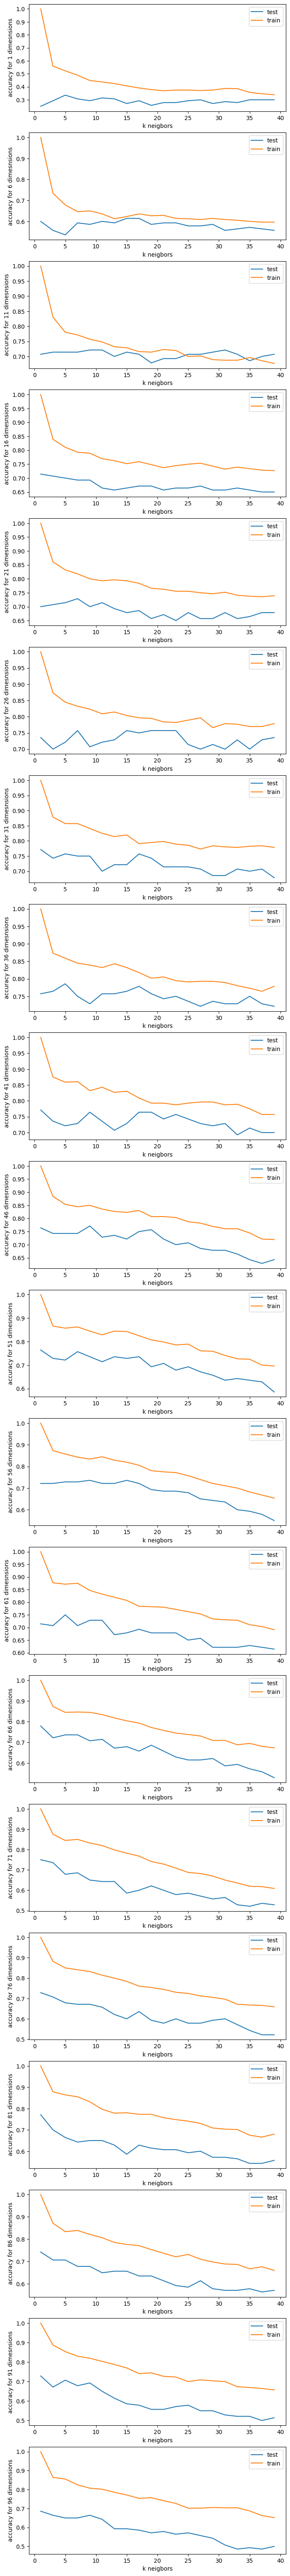

In [69]:
num_dim = len(n_components)

fig, ax = plt.subplots(num_dim, 1, figsize=(8, 4*num_dim))
for d in range(num_dim):
    ax[d].plot(k_neighbors, accuracies[d][0], label="test")
    ax[d].plot(k_neighbors, accuracies[d][1], label="train")
    ax[d].set_xlabel("k neigbors")
    ax[d].set_ylabel("accuracy for "+str(n_components[d])+" dimesnsions")
    ax[d].legend()

In [70]:
max_accuracy

{'score': 0.7857142857142857,
 'dim': 36,
 'k': 5,
 'model': KNeighborsClassifier(),
 'X_train': array([[ -4.35031073,  -1.38421749,   1.76606378, ...,   0.2035399 ,
           0.18973395,   0.26338187],
        [  7.05341183,   3.34730126,  -5.22014447, ...,  -0.30207949,
           0.02178235,  -0.07189056],
        [  6.20159564,  -0.17865212,   0.59244995, ...,   0.01144263,
          -0.35545651,  -0.49103234],
        ...,
        [ -9.48481318,   4.97719805,  -4.29838582, ...,   0.40821658,
          -0.50044545,   0.74630927],
        [  2.71826034,  -3.10979098,   0.8972341 , ...,   0.01320568,
          -0.42323902,  -0.94640042],
        [-10.11122014,   4.88426397,  -5.22104164, ...,   0.62991367,
          -0.51683932,   0.89856949]], shape=(560, 36)),
 'X_test': array([[ 4.84407220e-02,  1.17439305e+00,  1.03152138e+00, ...,
          9.06271591e-02, -1.31423220e-02,  2.04691911e-01],
        [-9.42985106e+00,  5.97395828e+00, -3.42405422e+00, ...,
          2.19077103e-0

##### Accuracy für bestes k in Abhängigkeit von n_components

In [71]:
#plotting accuracies for best k depending on n_components
best_k_index = k_neighbors.index(max_accuracy['k'])
nn_accuracies_test  = [acc[best_k_index][0] for acc in accuracies]
nn_accuracies_train = [acc[best_k_index][1] for acc in accuracies]

plt.plot(n_components, nn_accuracies_test, label ="test")
plt.plot(n_components, nn_accuracies_train, label="train")
plt.xlabel("no. of components for PCA")
plt.ylabel("accuracy")
plt.legend()
plt.title("KNN Classification for k = " + str(max_accuracy['k']))

IndexError: tuple index out of range

##### Confusion Matrix for best model

In [ ]:
#y_hat_test
#cm

NameError: name 'y_hat_test' is not defined

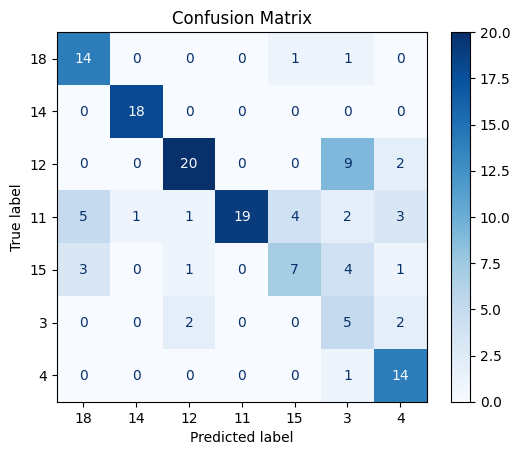

In [72]:
knn_model = max_accuracy['model']
y_hat_test = knn_model.predict(max_accuracy['X_test'])
cm = confusion_matrix(y_hat_test, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
our_bats

,bat,number
18,Zwergfledermaus,7885
14,Wasserfledermaus,6074
12,Rauschen,4713
11,Rauhautfledermaus,4695
15,Weißrandfledermaus,4619
3,Fransenfledermaus,3040
4,GroßerAbendsegler,3005


### 1.3 Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

flat_X_df_unscaled

,0,1,2,3,4,5,6,7,8,9,...,32758,32759,32760,32761,32762,32763,32764,32765,32766,32767
0,0.569934,0.569894,0.569852,0.569813,0.569753,0.569960,0.569509,0.569922,0.569620,0.570025,...,0.204258,0.102690,0.364744,0.510703,0.557572,0.584719,0.602516,0.614462,0.622115,0.626241
1,0.562711,0.563009,0.563220,0.563873,0.563603,0.562995,0.562986,0.563189,0.562879,0.563542,...,0.185969,0.110493,0.367022,0.518693,0.568408,0.597281,0.616222,0.628934,0.637070,0.641445
2,0.540672,0.540561,0.539030,0.542872,0.539791,0.540824,0.541568,0.540243,0.540415,0.541400,...,0.204121,0.118549,0.320888,0.475392,0.524052,0.552140,0.570541,0.582894,0.590816,0.595112
3,0.656532,0.656706,0.655695,0.656914,0.656673,0.656606,0.656534,0.656938,0.656943,0.656561,...,0.221336,0.193685,0.345573,0.517796,0.569493,0.599304,0.618818,0.631919,0.640329,0.644894
4,0.535316,0.533804,0.526298,0.533035,0.529025,0.530466,0.534960,0.529274,0.531082,0.528297,...,0.183068,0.112533,0.406536,0.556906,0.607322,0.636691,0.655971,0.668909,0.677180,0.681610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,0.674440,0.671448,0.674428,0.671537,0.674456,0.671508,0.674294,0.671676,0.674269,0.671942,...,0.013982,0.150725,0.393434,0.556518,0.610414,0.641749,0.662314,0.676116,0.684944,0.689683
696,0.708830,0.709127,0.709012,0.708612,0.708503,0.708768,0.708993,0.709051,0.708913,0.708767,...,0.238102,0.224397,0.473750,0.623981,0.673274,0.701914,0.720704,0.733314,0.741384,0.745722
697,0.532803,0.589453,0.576252,0.341130,0.586594,0.582583,0.527122,0.579325,0.585821,0.556562,...,0.138498,0.143389,0.394084,0.545252,0.595104,0.624088,0.643108,0.655872,0.664038,0.668422
698,0.691588,0.691381,0.691363,0.691083,0.691225,0.691166,0.691277,0.691274,0.691332,0.691147,...,0.239528,0.242758,0.488083,0.638146,0.687649,0.716432,0.735320,0.747996,0.756105,0.760458


In [ ]:
DecisionTreeClassifier(max_depth=3, criterion='gini')
heart_tree.fit(X_train_H, y_train_H)

### 2. Neural Net

In [98]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.utils import to_categorical  
from keras.layers import InputLayer,Dense, Activation, Conv2D, MaxPooling2D, Dropout, Flatten

#### CNN

In [124]:
X_3d = np.array(X_3d)
    
X_3d.shape

(700, 256, 128, 1)

In [125]:
train_img, test_img, train_labels, test_labels = train_test_split(X_3d, y, 
                                                    test_size=0.2, random_state=0)
y_dict = {18: 0, 14: 1, 12: 2, 11: 3, 15: 4, 3: 5, 4: 6}
train_labels = [y_dict[lab] for lab in train_labels]
test_labels  = [y_dict[lab] for lab in test_labels]

y_train = to_categorical(train_labels, num_classes=len(our_bats))
y_test = to_categorical(test_labels, num_classes=len(our_bats))

X_train = train_img.astype('float32')
X_test = test_img.astype('float32')

In [126]:
y_train.shape

(560, 7)

In [127]:
len(our_bats)

7

In [128]:
conv_model = Sequential()
conv_model.add(Conv2D(60, 
                      kernel_size=(3,3),
                      strides=(1,1), 
                      padding='same',
                      activation='relu', 
                      input_shape=(X_3d[0].shape)))
conv_model.add(MaxPooling2D(pool_size=(3,3), 
                            strides=(1,1)))
conv_model.add(Conv2D(30, 
                      kernel_size=(3,3),
                      strides=(1,1), 
                      padding='same',
                      activation='relu'))
conv_model.add(MaxPooling2D(pool_size=(3, 3),
                           strides=(1,1)))
conv_model.add(Flatten())
conv_model.add(Dense(64, activation='relu'))
conv_model.add(Dense(len(our_bats), activation='softmax'))      

adam_opt = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [129]:
conv_model.compile(
    optimizer=adam_opt,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [130]:
# Füge diese Zelle VOR Zelle 67 ein, um die Shape zu überprüfen und zu korrigieren:
print("Shape vor Korrektur:", X_3d[0].shape if len(X_3d) > 0 else "X_3d ist leer")

# Sicherstellen, dass X_3d die richtige Form hat (256, 128, 1)
if len(X_3d) > 0 and len(X_3d[0].shape) == 2:
    print("X_3d hat falsche Shape - wird korrigiert...")
    X_3d = [x.reshape(256, 128, 1) for x in X_3d]
    print("Shape nach Korrektur:", X_3d[0].shape)
elif len(X_3d) > 0:
    print("X_3d hat bereits die richtige Shape:", X_3d[0].shape)
else:
    print("FEHLER: X_3d ist leer!")

Shape vor Korrektur: (256, 128, 1)
X_3d hat bereits die richtige Shape: (256, 128, 1)


In [131]:
from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();

plot_losses = PlotLosses()

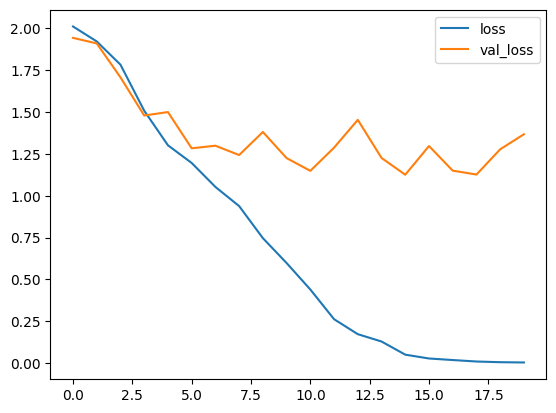

560/560 ━━━━━━━━━━━━━━━━━━━━ 65s 116ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 0.6071 - val_loss: 1.3670


In [132]:
history_conv_model=conv_model.fit(X_train, y_train,
                                  validation_data=(X_test, y_test),                              
                                  epochs=20,
                                  batch_size=1,
                                  callbacks=[plot_losses])

In [ ]:
## todo: callbacks implementieren, auflösung der bilder verringern